In [2]:
import warnings
import os
import time
import itertools

# Our numerical workhorse
import numpy as np
import scipy
import pandas as pd
import bebi103

# Image processing tools
import skimage
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.feature
import skimage.segmentation
import skimage.measure

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.filterwarnings('ignore')

# Part A

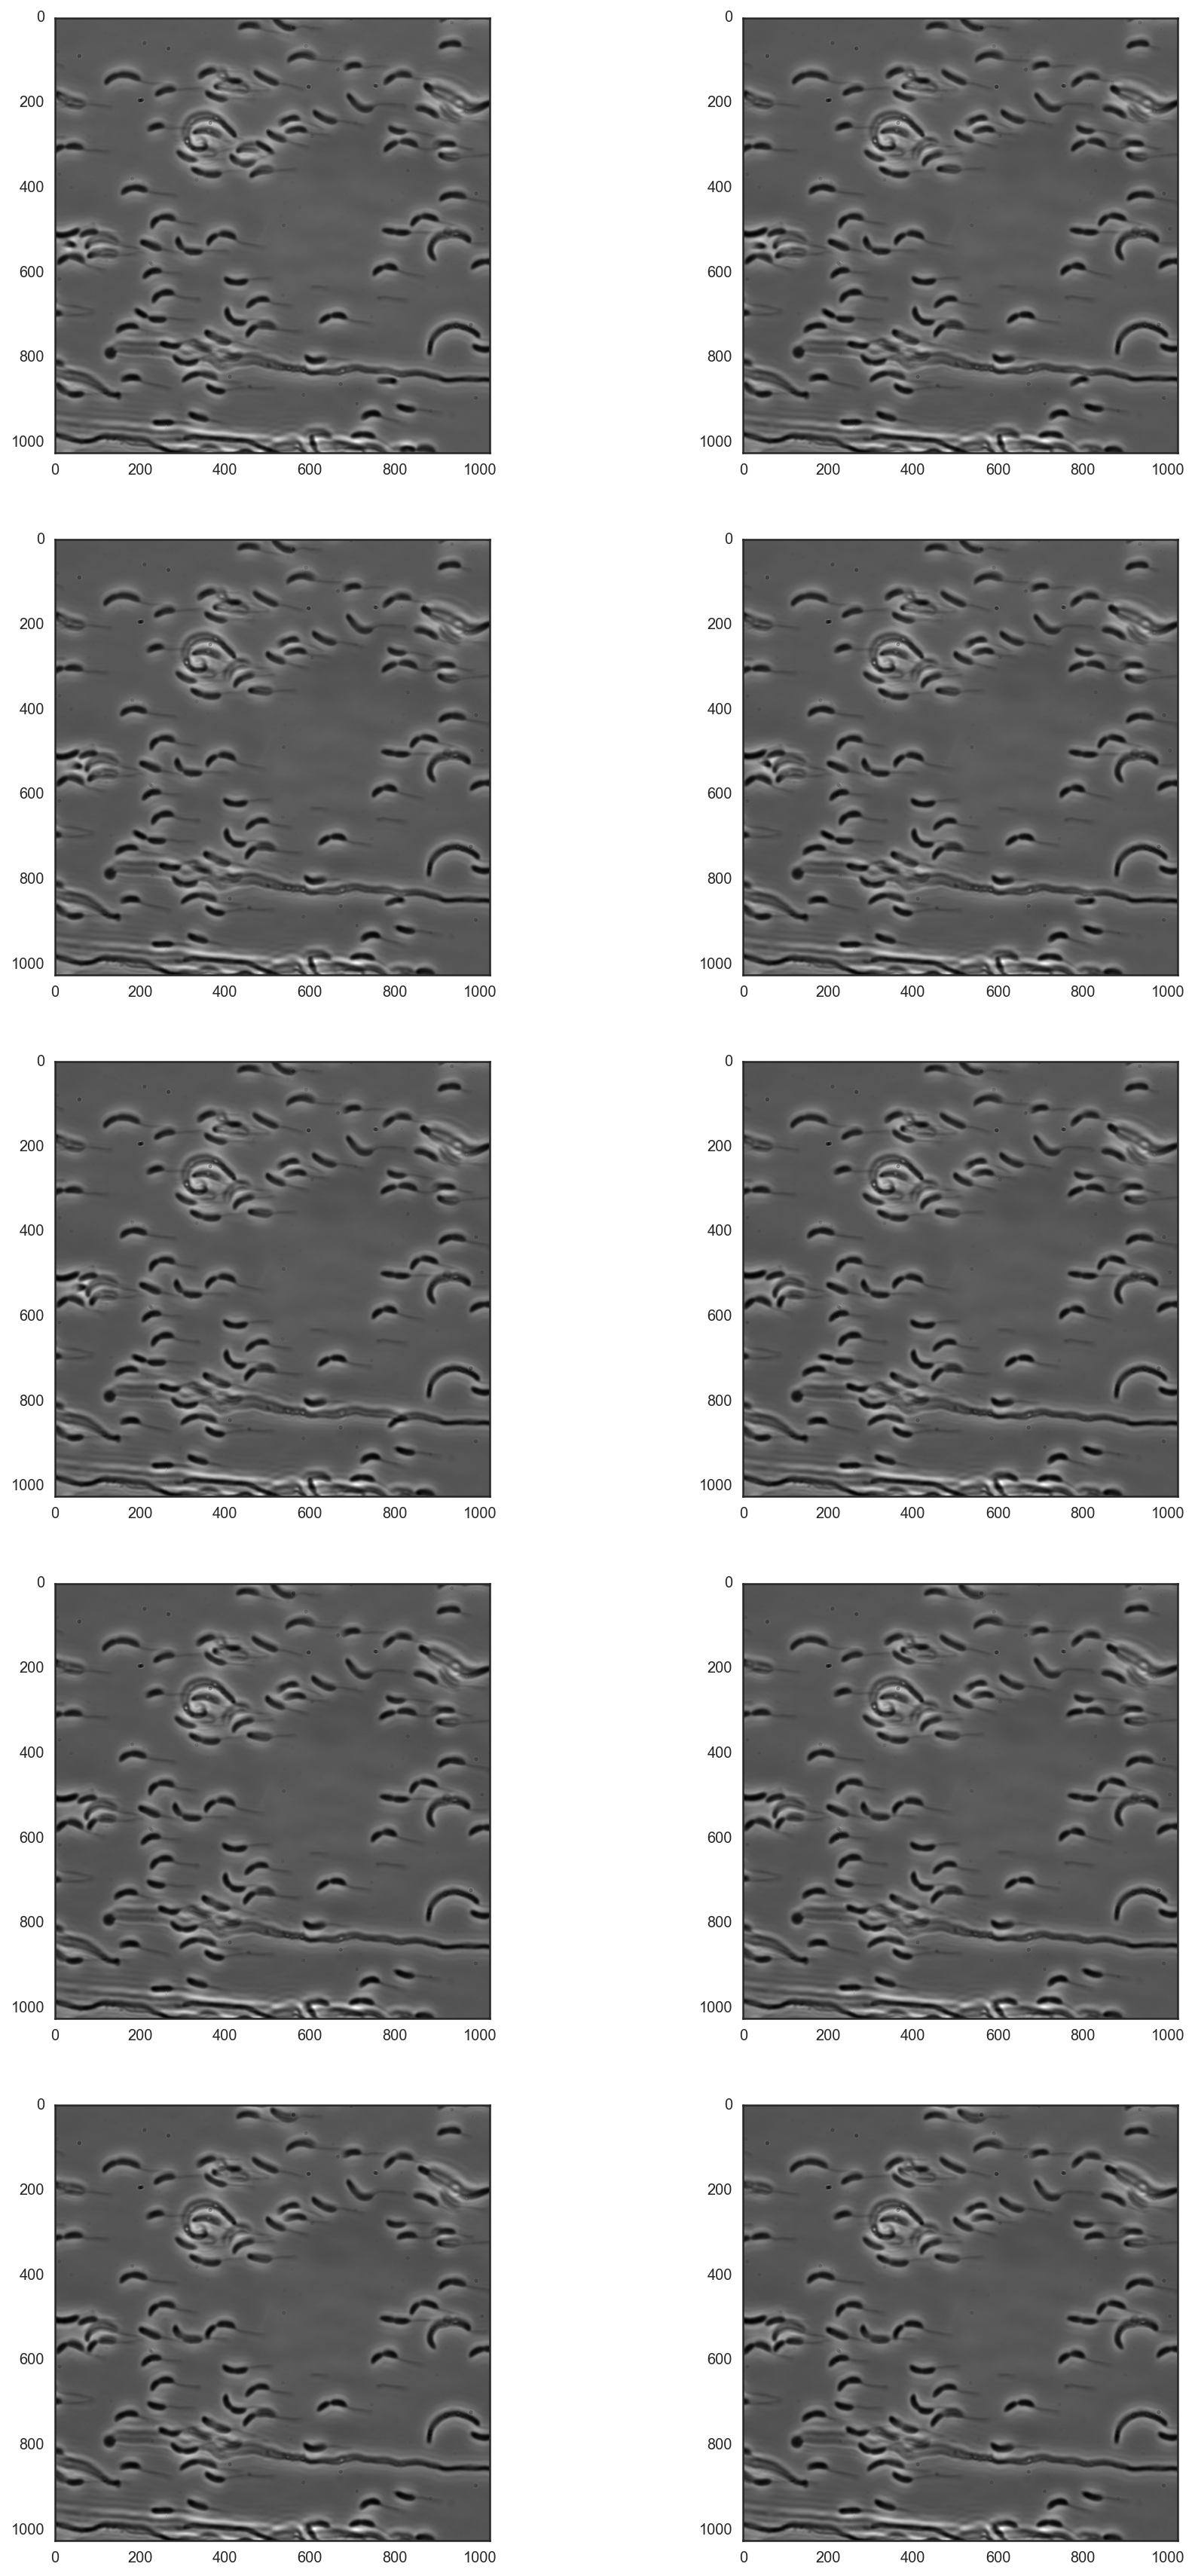

In [3]:
image_dir = '/Users/elenaperry/Dropbox/Caltech/bebi103/hw8_iyer-biswas_et_al\
/sequential_full_field/phase0300'

im_list = []
im_float_list = []
f = plt.figure(figsize=(15,30))

for i in range(10):
    im_list.append(image_dir + str(i) + '.tif')

    im = skimage.io.imread(im_list[i])
    im_float_list.append((im.astype(float) - im.min()) / (im.max() - im.min()))
    
for i in range(10):
    with sns.axes_style('white'):
        plt.subplot(5,2,i+1)
        plt.imshow(im_float_list[i], cmap=plt.cm.gray)

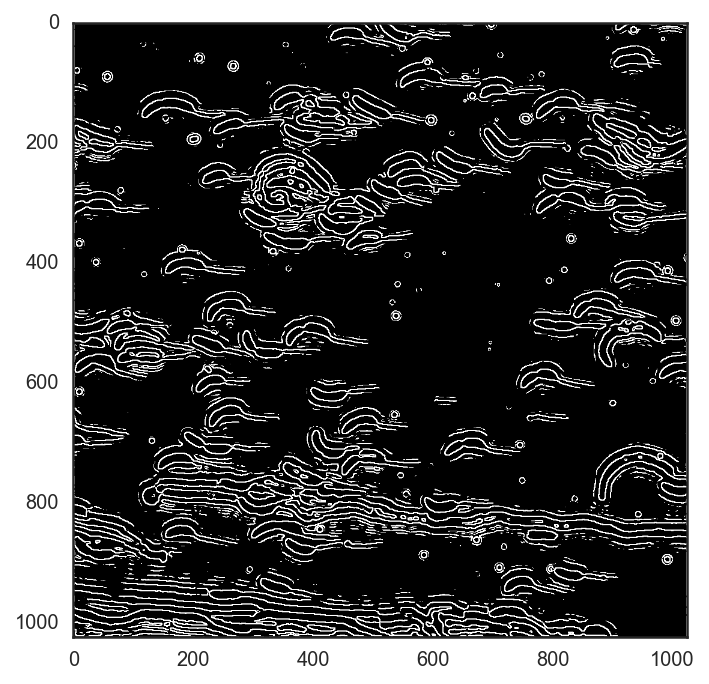

In [4]:
# Compute LoG
im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float_list[0], 2.0)

def zero_crossing_filter(im, thresh):
    """
    Returns image with 1 if there is a zero crossing and 0 otherwise.
    
    thresh is the the minimal value of the gradient, as computed by Sobel
    filter, at crossing to count as a crossing.
    """
    # Square structuring element
    selem = skimage.morphology.square(3)
    
    # Do max filter and min filter
    im_max = scipy.ndimage.filters.maximum_filter(im, footprint=selem)
    im_min = scipy.ndimage.filters.minimum_filter(im, footprint=selem)
    
    # Compute gradients using Sobel filter
    im_grad = skimage.filters.sobel(im)
    
    # Return edges
    return (((im >= 0) & (im_min < 0)) | ((im <= 0) & (im_max > 0))) \
                & (im_grad >= thresh)

# Find zero-crossings
im_edge = zero_crossing_filter(im_LoG, 0.001)

# Show result
with sns.axes_style('white'):
    plt.imshow(im_edge, cmap=plt.cm.gray)

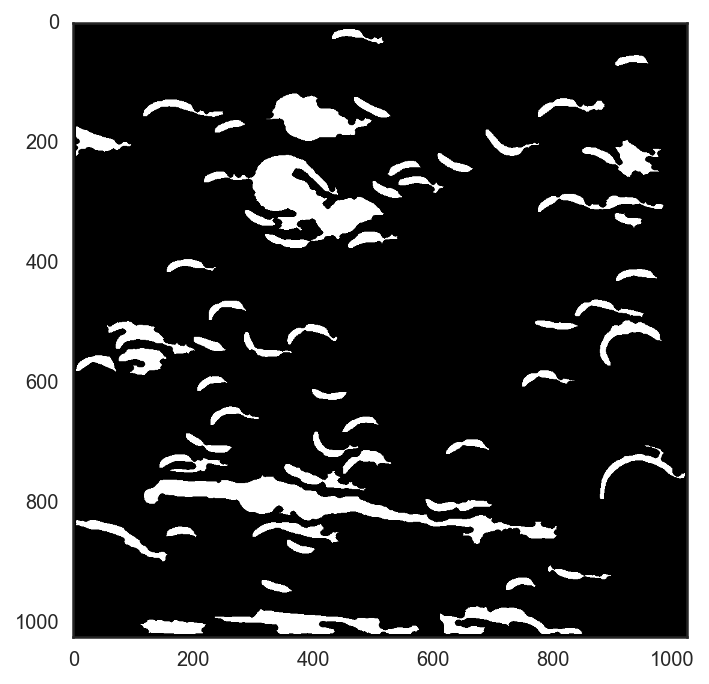

In [5]:
# Structuring element is radius 2 disk
selem = skimage.morphology.disk(2)

# Close binary image
im_bw_close = skimage.morphology.binary_closing(im_edge, selem)

# Remove small objectes that are not bacteria
im_bw = skimage.morphology.remove_small_objects(im_bw_close, min_size=500)

# Fill holes
im_bw = scipy.ndimage.morphology.binary_fill_holes(im_bw)

# Structuring element is radius 3 disk
selem = skimage.morphology.disk(3)

# Erode binary image again
im_bw_eroded = skimage.morphology.erosion(im_bw, selem)

# Remove small objectes that are not bacteria
im_bw = skimage.morphology.remove_small_objects(im_bw_eroded, min_size=500)

# Show result
with sns.axes_style('white'):
    fig = plt.imshow(im_bw, cmap=plt.cm.gray).get_figure()
    fig.savefig('output.png')

Bacteria we believe are not suitable to gather long time course imaging are the bacteria that are in the middle of this tail, blur (circled in cyan below). This stream causes problems when we try to segment the image; althought the stream is part of the background, it has a lower intensity than the background and is distinguished as a cell in our segmentation. Other cells we believe are not suitable to gather long time course imaging are the bacteria are the ones circled in yellow below. Attempts to segement out bacteria where there are clumped together result in images where the bacteria aren't accurately segmented. We suggest that the bacteria best suitable to gather long time course imaging are the bacteria that have no neighbors. The bacteria that we think is best for analysis are circled in red below. 

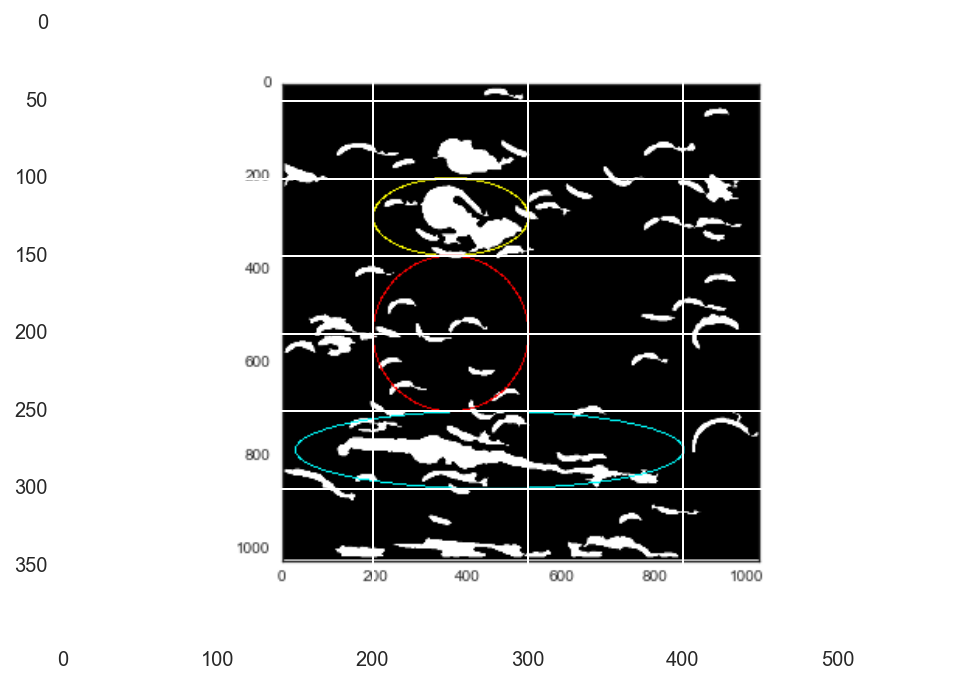

In [6]:
pic = Image.open('output.png')
draw = ImageDraw.Draw(pic)
draw.ellipse((150, 250, 400, 300), outline='cyan')
draw.ellipse((150+50, 100, 300, 150), outline='yellow')
draw.ellipse((200, 150, 300, 250), outline='red')
plt.imshow(pic)

# Part B

In [7]:
image_dir = '/Users/elenaperry/Dropbox/Caltech/bebi103/hw8_iyer-biswas_et_al/'
im_bac_1_file = os.path.join(image_dir, 'bacterium_1.tif')
im_bac_2_file = os.path.join(image_dir, 'bacterium_2.tif')

im_bac_1 = skimage.io.imread(im_bac_1_file)
im_bac_2 = skimage.io.imread(im_bac_2_file)

im_bac_1_float = np.empty(im_bac_1.shape)
for i in range(len(im_bac_1)):
    im_bac_1_float[i] = (im_bac_1[i].astype(float) - im_bac_1[i].min()) / (im_bac_1[i].max() - im_bac_1[i].min())

im_bac_2_float = np.empty(im_bac_2.shape)
for i in range(len(im_bac_2)):
    im_bac_2_float[i] = (im_bac_2[i].astype(float) - im_bac_2[i].min()) / (im_bac_2[i].max() - im_bac_2[i].min())

In [8]:
def segment_bacteria(im, bac):
    
    if bac == 1:
        gaussian_blur = 3.0
        zero_crossing_thresh = 0.002
        selem_size = 4
    elif bac == 2:
        gaussian_blur = 5.0
        zero_crossing_thresh = 0.0008
        selem_size = 5
        
    # Compute LoG
    im_LoG = scipy.ndimage.filters.gaussian_laplace(im, gaussian_blur)

    # Find zero-crossings
    im_edge = zero_crossing_filter(im_LoG, zero_crossing_thresh)

    # Structuring element is radius 2 disk
    selem = skimage.morphology.disk(selem_size)

    # Close binary image
    im_bw_close = skimage.morphology.binary_closing(im_edge, selem)

    im_skel = skimage.morphology.skeletonize(im_bw_close)

    # Fill holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_skel)

    # Remove small objectes that are not bacteria
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=50)

    return im_bw

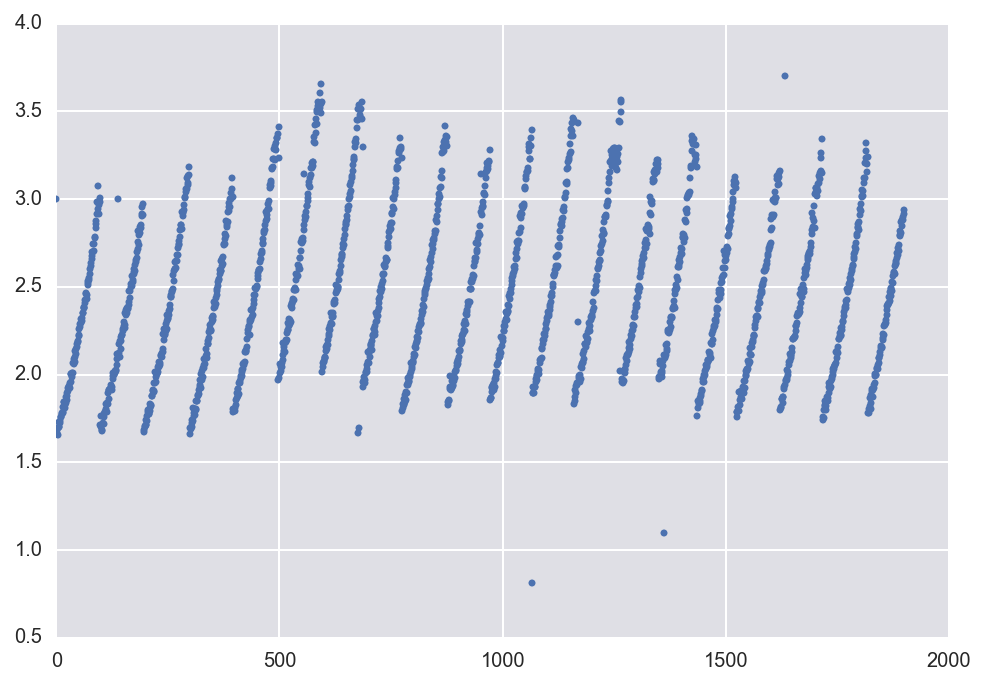

In [9]:
max_area = np.array([0.01] * len(im_bac_1_float))
for i in range(len(im_bac_1_float)):
    im_bw = segment_bacteria(im_bac_1_float[i], 1)
    # Label binary image
    im_labeled, n_labels = skimage.measure.label(im_bw, background=-1, return_num=True)

    # Get area of each bacterium and store the largest area in case of more than one bacterium
    physical_size = 0.052
    im_props = skimage.measure.regionprops(im_labeled)
    for prop in im_props:
        if prop.area * physical_size**2 > max_area[i]:
            max_area[i] = prop.area * physical_size**2

plt.plot(np.arange(len(im_bac_1_float)), max_area, '.')

In [10]:
too_small = np.where(max_area < 1.5)
print('too small: ' + str(too_small))

too small: (array([1066, 1361]),)


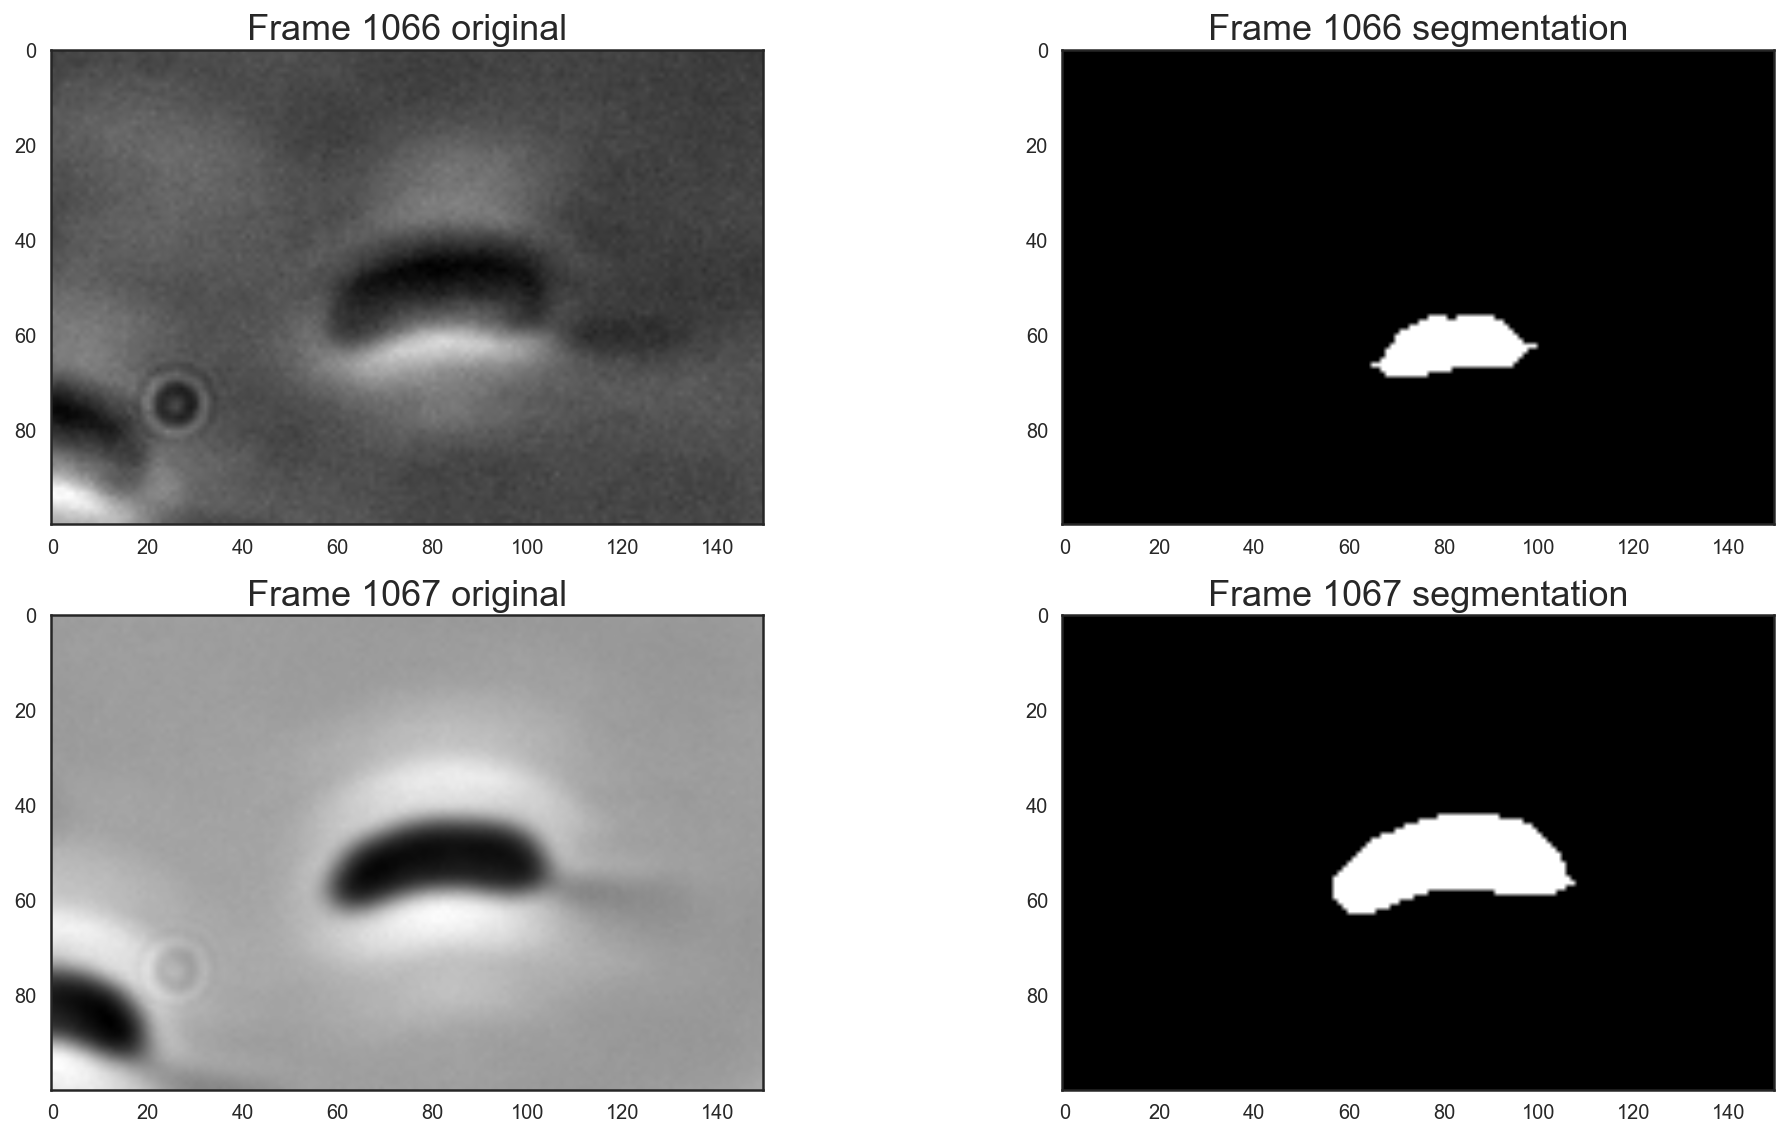

In [11]:
inds = [1066, 1067]
im_bw = np.empty((2, 100, 150))
im_orig = np.empty((2, 100, 150))
for ind, i in enumerate(inds):
    im_bw[ind] = segment_bacteria(im_bac_1_float[i], 1)
    im_orig[ind] = im_bac_1_float[i]
    
with sns.axes_style('white'):
    f = plt.figure(figsize=(15,8))    
    plt.subplot(2,2,1)
    plt.imshow(im_orig[0], cmap=plt.cm.gray)
    plt.title('Frame 1066 original')
    plt.subplot(2,2,2)
    plt.imshow(im_bw[0], cmap=plt.cm.gray)
    plt.title('Frame 1066 segmentation')
    plt.subplot(2,2,3)
    plt.imshow(im_orig[1], cmap=plt.cm.gray)
    plt.title('Frame 1067 original')
    plt.subplot(2,2,4)
    plt.title('Frame 1067 segmentation')
    plt.imshow(im_bw[1], cmap=plt.cm.gray)
    plt.tight_layout()

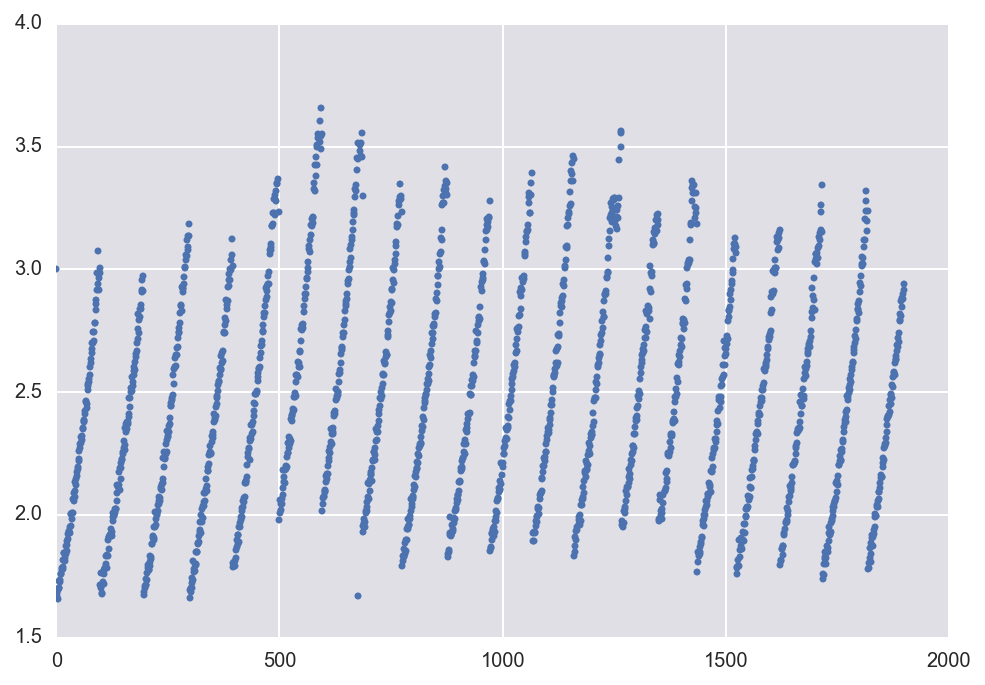

In [12]:
# Copy the array of max areas in case we need the original later
new_max_area = np.copy(max_area)

# Drop outliers, which we define as points where the jump to the next point
# is greater than +0.3
area_diff = np.concatenate((np.array([0.1]), np.diff(new_max_area)))
new_areas = new_max_area[area_diff < 0.3]
new_area_diff = np.concatenate((np.diff(new_areas), np.array([0.1])))
new_areas = new_areas[new_area_diff < 0.3]
times = np.arange(len(new_max_area))[area_diff < 0.3]
times = times[new_area_diff < 0.3]

# Take a look
plt.plot(times, new_areas, '.')

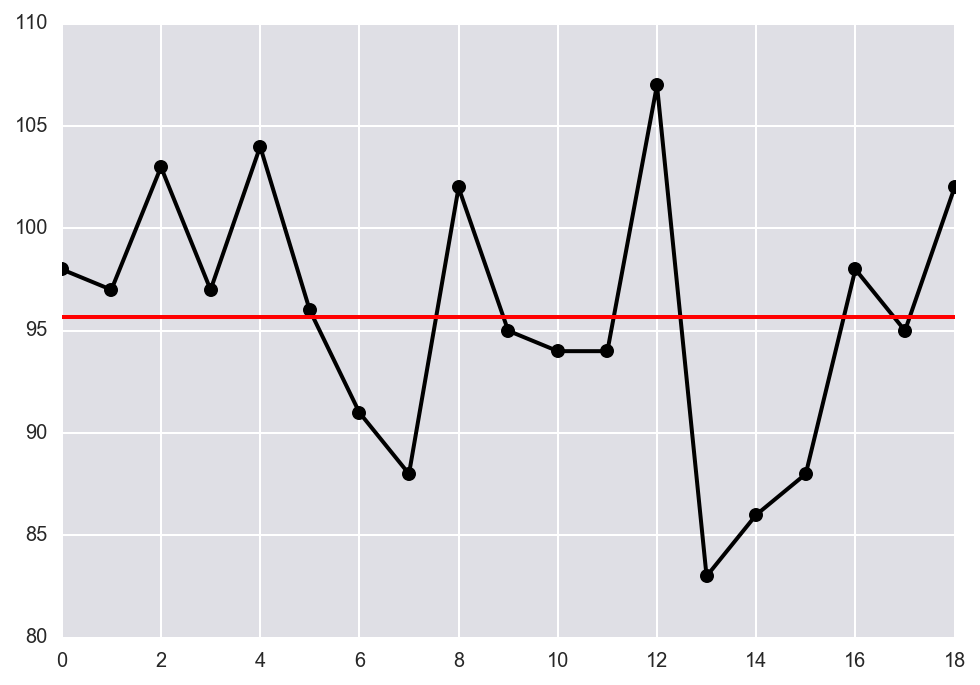

In [13]:
final_area_diffs = np.concatenate((np.diff(new_areas), np.array([0.1])))
inter_div_inds = times[final_area_diffs < -1.0]
inter_div_inds_list = []
for i in np.arange(1, len(inter_div_inds)):
    if inter_div_inds[i] - inter_div_inds[i-1] > 50:
        inter_div_inds_list.append(inter_div_inds[i-1])
if inter_div_inds[-1] - inter_div_inds[-2] > 50:
    inter_div_inds_list.append(inter_div_inds[-1])
inter_div_inds = np.array(inter_div_inds_list) 
inter_div_time = np.diff(inter_div_inds)

plt.plot(np.arange(len(inter_div_time)), inter_div_time, marker='o', color='k')
plt.plot(np.arange(len(inter_div_time)), [np.mean(inter_div_time)]*len(inter_div_time), color='r')

# Bacterium 2

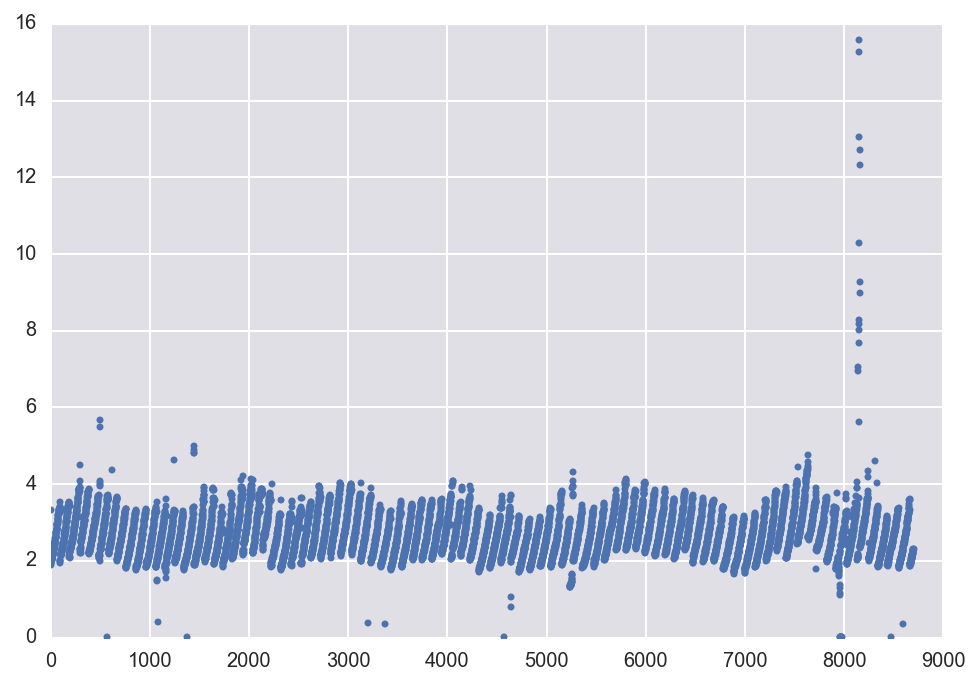

In [14]:
max_area2 = np.array([0.01] * len(im_bac_2_float))
for i in range(len(im_bac_2_float)):
    im_bw = segment_bacteria(im_bac_2_float[i], 2)
    # Label binary image
    im_labeled, n_labels = skimage.measure.label(im_bw, background=-1, return_num=True)

    # Get area of each bacterium and store the largest area in case of more than one bacterium
    physical_size = 0.052
    im_props = skimage.measure.regionprops(im_labeled)
    for prop in im_props:
        if prop.area * physical_size**2 > max_area2[i]:
            max_area2[i] = prop.area * physical_size**2

plt.plot(np.arange(len(im_bac_2_float)), max_area2, '.')

In [15]:
too_big = np.where(max_area2 > 6)
too_small = np.where(max_area2 < 1)

print('too big: ' + str(too_big))
print('too small: ' + str(too_small))

too big: (array([8142, 8143, 8146, 8147, 8148, 8149, 8150, 8151, 8152, 8153, 8154,
       8155, 8156, 8157]),)
too small: (array([ 568, 1080, 1375, 3195, 3368, 4568, 4642, 7961, 7962, 7963, 7964,
       7965, 7969, 7970, 7979, 8471, 8591]),)


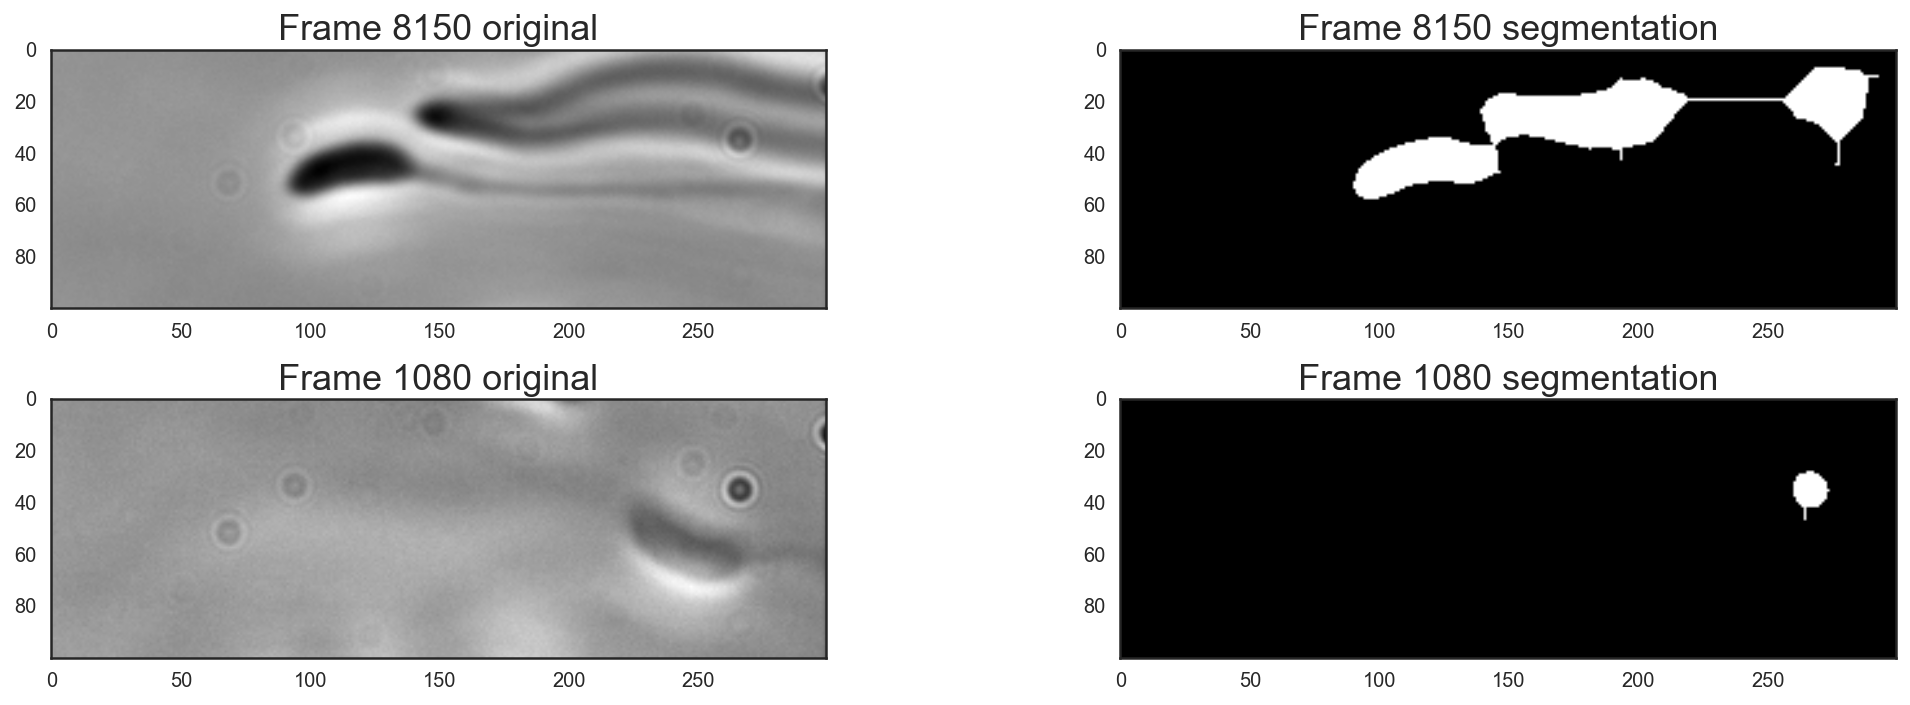

In [16]:
bad_inds = [8150, 1080]
im_bw = np.empty((2, 100, 300))
im_orig = np.empty((2, 100, 300))
for ind, i in enumerate(bad_inds):
    im_bw[ind] = segment_bacteria(im_bac_2_float[i], 2)
    im_orig[ind] = im_bac_2_float[i]
    
with sns.axes_style('white'):
    f = plt.figure(figsize=(15,5))    
    plt.subplot(2,2,1)
    plt.imshow(im_orig[0], cmap=plt.cm.gray)
    plt.title('Frame 8150 original')
    plt.subplot(2,2,2)
    plt.imshow(im_bw[0], cmap=plt.cm.gray)
    plt.title('Frame 8150 segmentation')
    plt.subplot(2,2,3)
    plt.imshow(im_orig[1], cmap=plt.cm.gray)
    plt.title('Frame 1080 original')
    plt.subplot(2,2,4)
    plt.imshow(im_bw[1], cmap=plt.cm.gray)
    plt.title('Frame 1080 segmentation')
    plt.tight_layout()

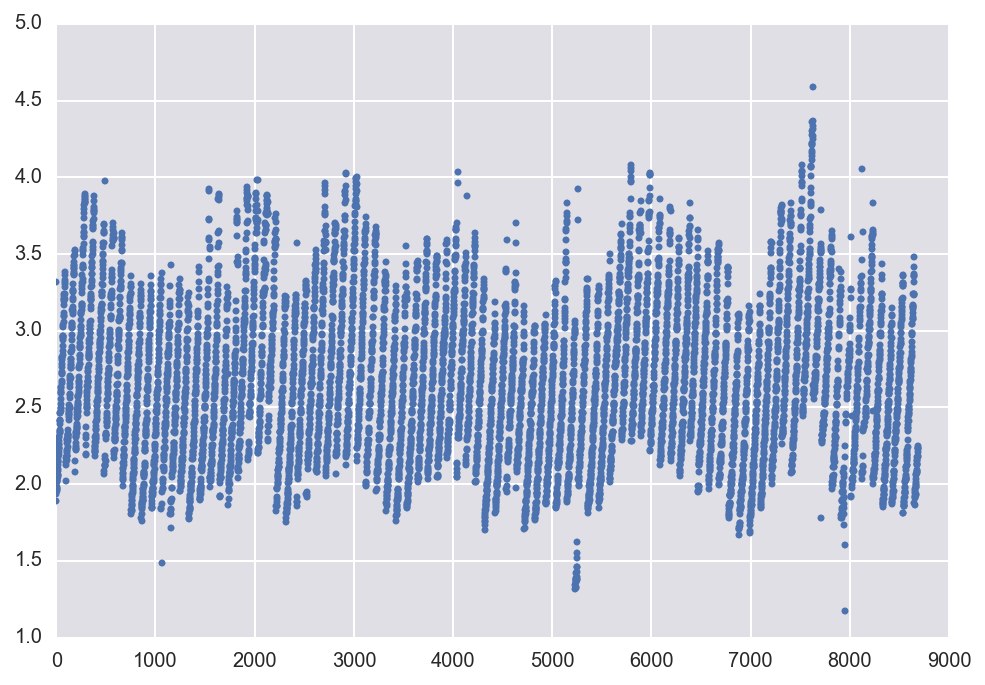

In [17]:
# Copy the array of max areas in case we need the original later
new_max_area2 = np.copy(max_area2)

# Drop outliers, which we define as points where the jump to the next point
# is greater than +0.3
area_diff2 = np.concatenate((np.array([0.1]), np.diff(new_max_area2, n=3)))
new_areas2 = new_max_area2[area_diff2 < 0.3]
new_area_diff2 = np.concatenate((np.diff(new_areas2, n=3), np.array([0.1])))
new_areas2 = new_areas2[new_area_diff2 < 0.3]
new_areas2 = new_areas2[new_areas2 < 5]
new_areas2 = new_areas2[new_areas2 > 1]
times2 = np.arange(len(new_max_area2))[area_diff2 < 0.3]
times2 = times2[new_area_diff2 < 0.3]
times2 = times2[new_areas2 < 5]
times2 = times2[new_areas2 > 1]

# Take a look
plt.plot(times2, new_areas2, '.')

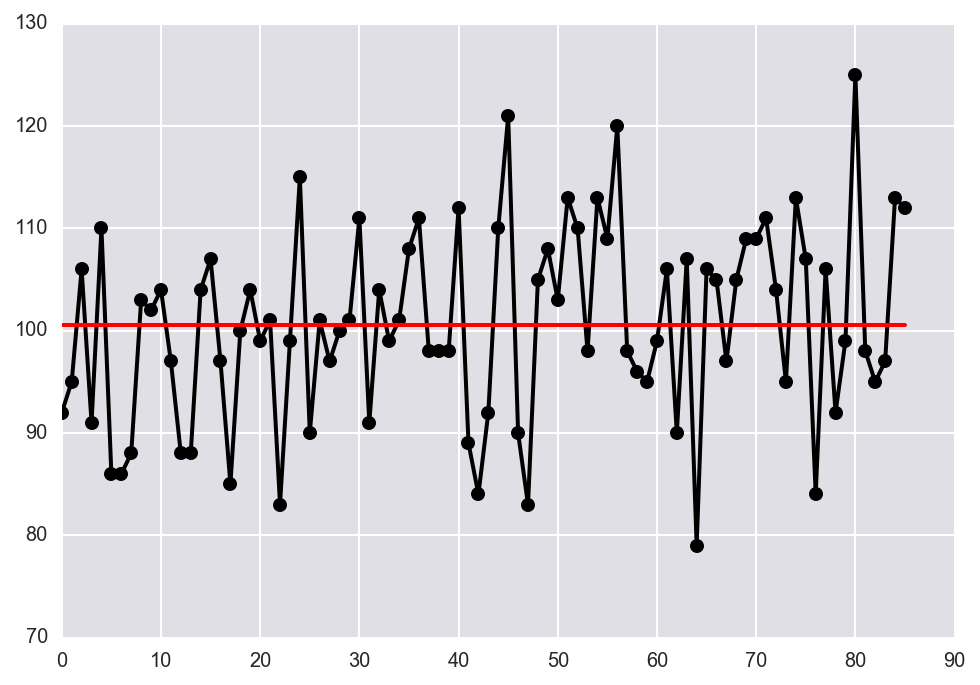

In [18]:
final_area_diffs2 = np.concatenate((np.diff(new_areas2), np.array([0.1])))
inter_div_inds2 = times2[final_area_diffs2 < -1.2]
inter_div_inds_list2 = []
for i in np.arange(1, len(inter_div_inds2)):
    if inter_div_inds2[i] - inter_div_inds2[i-1] > 50:
        inter_div_inds_list2.append(inter_div_inds2[i-1])
if inter_div_inds2[-1] - inter_div_inds2[-2] > 50:
    inter_div_inds_list2.append(inter_div_inds2[-1])
inter_div_inds2 = np.array(inter_div_inds_list2)        
inter_div_time2 = np.diff(inter_div_inds2)

plt.plot(np.arange(len(inter_div_time2)), inter_div_time2, marker='o', color='k')
plt.plot(np.arange(len(inter_div_time2)), [np.mean(inter_div_time2)]*len(inter_div_time2), color='r')

# Part C

In [19]:
inter_div_inds = np.where(final_area_diffs < -1.0)[0]
inter_div_inds_list = []
for i in np.arange(1, len(inter_div_inds)):
    if inter_div_inds[i] - inter_div_inds[i-1] > 50:
        inter_div_inds_list.append(inter_div_inds[i-1])
if inter_div_inds[-1] - inter_div_inds[-2] > 50:
    inter_div_inds_list.append(inter_div_inds[-1])
inter_div_inds = np.array(inter_div_inds_list) 
inds1 = inter_div_inds + 1
init_areas1 = np.empty(len(inds1))
for i, ind in enumerate(inds1):
    init_areas1[i] = new_areas[ind]
inds1 = np.concatenate((inds1, np.array([len(new_areas)-1])))
min_area1 = init_areas1.min()
area_series1 = []
time_series1 = []
for i in range(len(inds1)-1):
    area_series1.append(new_areas[inds1[i]:inds1[i+1]])
    time_series1.append(times[inds1[i]:inds1[i+1]])

inter_div_inds2 = np.where(final_area_diffs2 < -1.2)[0]
inter_div_inds_list2 = []
for i in np.arange(1, len(inter_div_inds2)):
    if inter_div_inds2[i] - inter_div_inds2[i-1] > 50:
        inter_div_inds_list2.append(inter_div_inds2[i-1])
if inter_div_inds2[-1] - inter_div_inds2[-2] > 50:
    inter_div_inds_list2.append(inter_div_inds2[-1])
inter_div_inds2 = np.array(inter_div_inds_list2)
inds2 = inter_div_inds2 + 1
init_areas2 = np.empty(len(inds2))
for i, ind in enumerate(inds2):
    init_areas2[i] = new_areas2[ind]
inds2 = np.concatenate((inds2, np.array([len(new_areas2)-1])))
min_area2 = init_areas2.min()
area_series2 = []
time_series2 = []
for i in range(len(inds2)-1):
    area_series2.append(new_areas2[inds2[i]:inds2[i+1]])
    time_series2.append(times2[inds2[i]:inds2[i+1]])

In [20]:
def exp_theor(params, times):
    a_0, k  = params
    return a_0 * np.exp(k * times)

def lin_theor(params, times):
    a_0, b = params
    return a_0 + b * times

def log_like(params, times, areas, model):
    
    if model == 'lin_theor':  
        a_0, b = params
        areas_theor = lin_theor(params, times)
    elif model == 'exp_theor':
        a_0, k = params
        areas_theor = exp_theor(params, times)
    return -len(times) / 2 * np.log(np.sum((areas - areas_theor)**2))

def log_prior(params, model, a_max=4, a_min=1e-6, k_max=0.01, k_min=1e-6, b_max=10, b_min=1e-6):
    if model == 'exp_theor':
        a_0, k = params
        if a_0 < a_min or a_0 > a_max or k < k_min or k > k_max:
            return -np.inf

        prior = np.empty(2)
        prior[0] = a_0 * np.log(a_max / a_min)
        prior[1] = k * np.log(k_max / k_min)
    
        return -np.log(prior).sum()
       
    elif model == 'lin_theor':
        a_0, b = params
        if a_0 < a_min or a_0 > a_max or b < b_min or b > b_max:
            return -np.inf
        prior = b * np.log(b_max / b_min)
        return -np.log(prior)
    
def params_start(n_walkers, n_temps, model, a_max=4, a_min=1e-6,
                 k_max=0.01, k_min=1e-6, b_max=0.1, b_min=1e-6, n_dim=2):
    """
    Generates starting points for each tau.
    """
    params = np.empty((n_temps, n_walkers, n_dim))
    
    if model == 'exp_theor':
        params[:,:,0] = np.random.uniform(a_min, a_max, (n_temps,n_walkers))
        params[:,:,1] = np.random.uniform(k_min, k_max, (n_temps,n_walkers))
    elif model == 'lin_theor':
        params[:,:,0] = np.random.uniform(a_min, a_max, (n_temps,n_walkers))
        params[:,:,1] = np.random.uniform(b_min, b_max, (n_temps,n_walkers))
    return params

In [21]:
def sample_ptmcmc(times, areas, model, n_temps=20, n_walkers=100, n_burn=100, 
                  n_steps=500, threads=None):
    """
    Sample posterior using PTMCMC.
    """
    # arguments for likelihood
    loglargs = (times, areas, model)
    
    # arguments for prior
    logpargs = (model,)
    
    # starting points for the parameters
    p0 = params_start(n_walkers, n_temps, model)
    
    # column headings for outputted DataFrames
    columns = {'lin_theor': ['a_0', 'b'],
               'exp_theor': ['a_0', 'k']}
    
    return bebi103.run_pt_emcee(
            log_like, log_prior, n_burn, n_steps,
            n_temps=n_temps, p0=p0, loglargs=loglargs, logpargs=logpargs,
            threads=threads, columns=columns[model], return_lnZ=True)

In [22]:
start = time.time()
df_1_lin, lnZ_1_lin, dlnZ_1_lin = sample_ptmcmc(time_series1[1], area_series1[1], 'lin_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

start = time.time()
df_9_lin, lnZ_9_lin, dlnZ_9_lin = sample_ptmcmc(time_series1[9], area_series1[9], 'lin_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

start = time.time()
df_16_lin, lnZ_16_lin, dlnZ_16_lin = sample_ptmcmc(time_series1[16], area_series1[16], 'lin_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

start = time.time()
df_1_exp, lnZ_1_exp, dlnZ_1_exp = sample_ptmcmc(time_series1[1], area_series1[1], 'exp_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

start = time.time()
df_9_exp, lnZ_9_exp, dlnZ_9_exp = sample_ptmcmc(time_series1[9], area_series1[9], 'exp_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

start = time.time()
df_16_exp, lnZ_16_exp, dlnZ_16_exp = sample_ptmcmc(time_series1[16], area_series1[16], 'exp_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

PTMCMC took 37.44888496398926  seconds.
PTMCMC took 37.29881501197815  seconds.
PTMCMC took 37.42787718772888  seconds.
PTMCMC took 42.7173171043396  seconds.
PTMCMC took 41.90772199630737  seconds.
PTMCMC took 41.93698215484619  seconds.


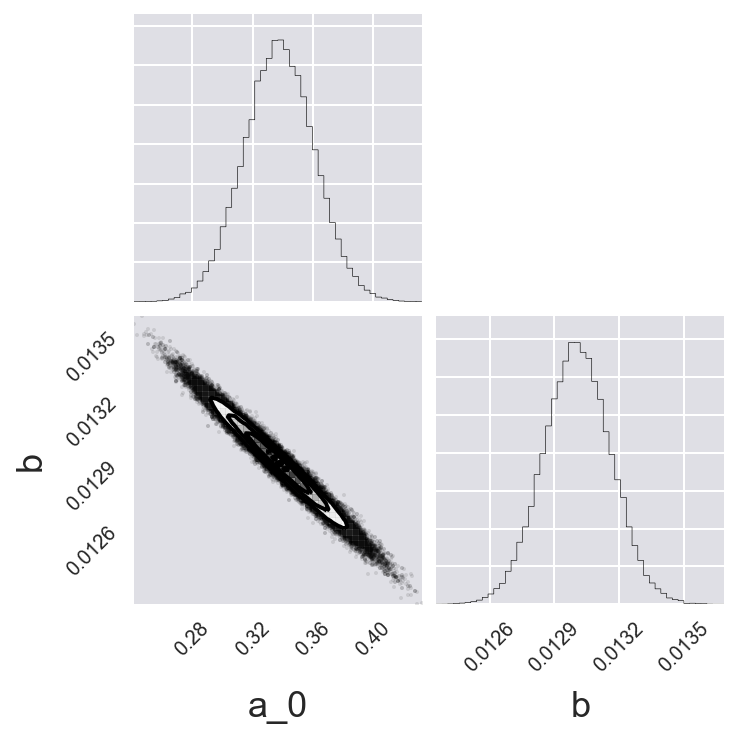

In [23]:
_ = corner.corner(df_9_lin[df_9_lin.beta_ind==0][['a_0', 'b']], bins=50)

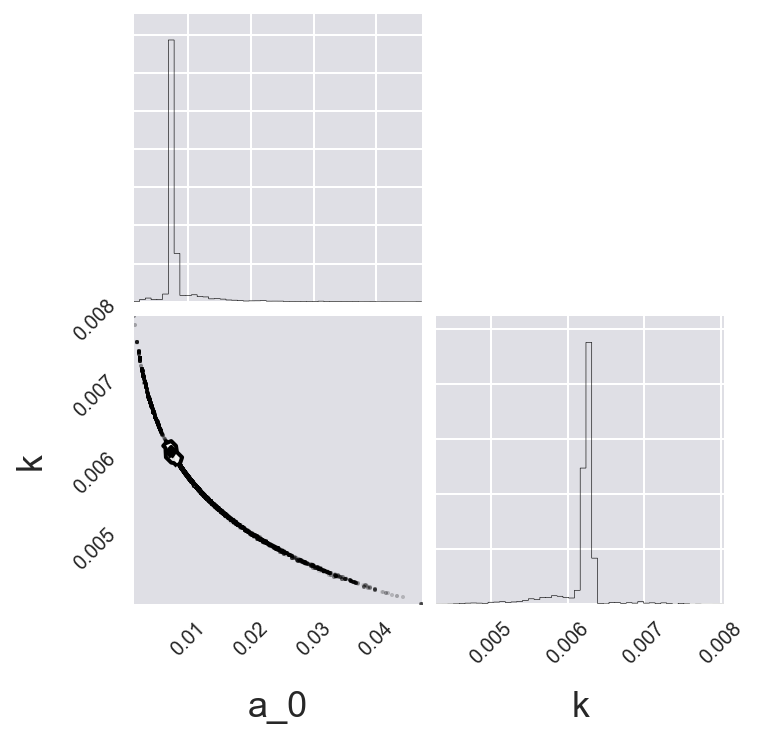

In [40]:
_ = corner.corner(df_9_exp[df_9_exp.beta_ind==0][['a_0', 'k']], bins=50)

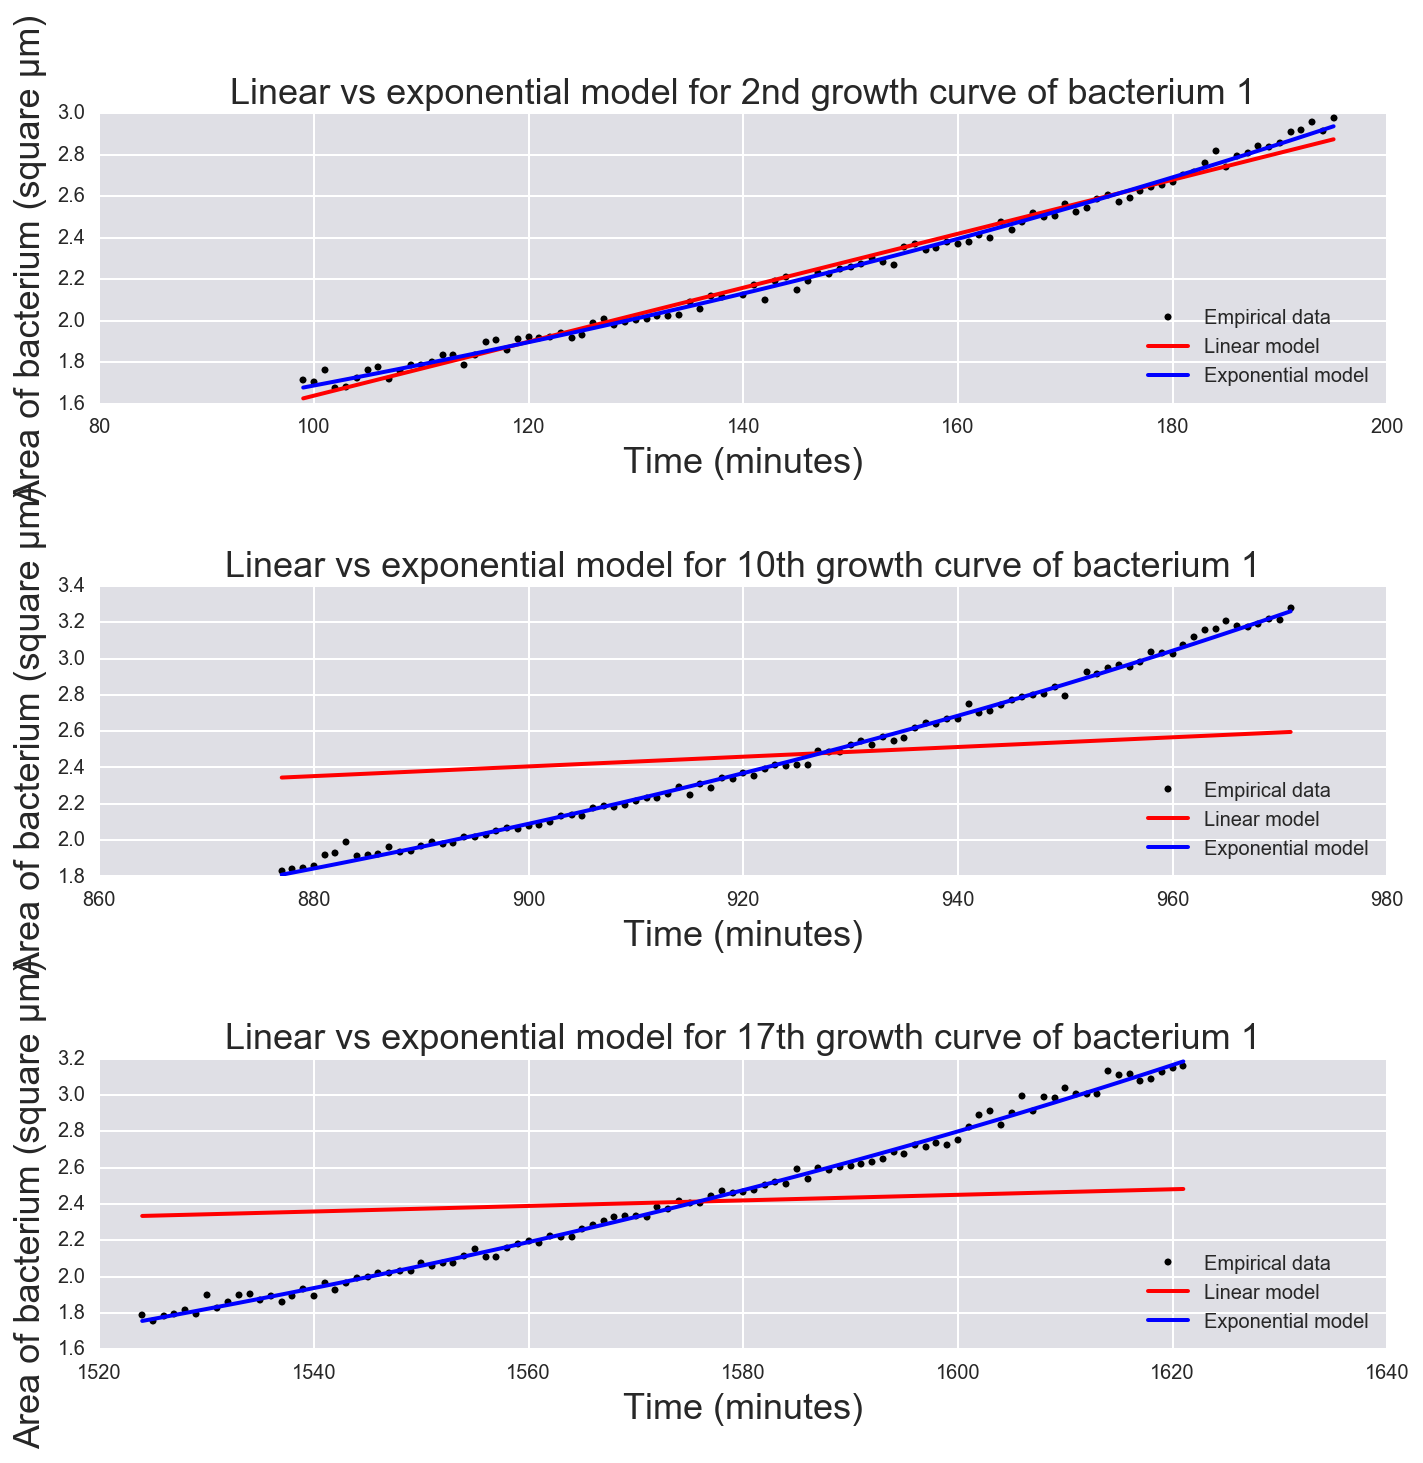

In [41]:
df_list = [df_1_lin, df_1_exp, df_9_lin, df_9_exp, df_16_lin, df_16_exp]
map1 = []
map2 = []

for i in range(len(df_list)):
    # Get the index of the most probable parameter set
    df_map = df_list[i][df_list[i].beta_ind == 0]
    max_ind = np.argmax(df_map.lnprob.values)

    # Pull out values.
    map_1, map_2 = df_map.values[max_ind, :2]
    map1.append(map_1)
    map2.append(map_2)

f = plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(time_series1[1], area_series1[1], '.', color='k')
plt.plot(time_series1[1],
         lin_theor(np.array([map1[0], map2[0]]), time_series1[1]), color='r')
plt.plot(time_series1[1],
         exp_theor(np.array([map1[1], map2[1]]), time_series1[1]), color='b')
plt.title('Linear vs exponential model for 2nd growth curve of bacterium 1')
plt.xlabel('Time (minutes)')
plt.ylabel('Area of bacterium (square µm)')
plt.legend(['Empirical data', 'Linear model', 'Exponential model'], loc=4)

plt.subplot(3,1,2)
plt.plot(time_series1[9], area_series1[9], '.', color='k')
plt.plot(time_series1[9],
         lin_theor(np.array([map1[2], map2[2]]), time_series1[9]), color='r')
plt.plot(time_series1[9],
         exp_theor(np.array([map1[3], map2[3]]), time_series1[9]), color='b')
plt.title('Linear vs exponential model for 10th growth curve of bacterium 1')
plt.xlabel('Time (minutes)')
plt.ylabel('Area of bacterium (square µm)')
plt.legend(['Empirical data', 'Linear model', 'Exponential model'], loc=4)

plt.subplot(3,1,3)
plt.plot(time_series1[16], area_series1[16], '.', color='k')
plt.plot(time_series1[16],
         lin_theor(np.array([map1[4], map2[4]]), time_series1[16]), color='r')
plt.plot(time_series1[16],
         exp_theor(np.array([map1[5], map2[5]]), time_series1[16]), color='b')
plt.title('Linear vs exponential model for 17th growth curve of bacterium 1')
plt.xlabel('Time (minutes)')
plt.ylabel('Area of bacterium (square µm)')
plt.legend(['Empirical data', 'Linear model', 'Exponential model'], loc=4)
plt.tight_layout()

In [43]:
map2

[0.013006363701322521,
 0.0058329199645424518,
 0.0026727542575126161,
 0.00626348499653434,
 0.0015313110747411048,
 0.0061396390868946674]

In [26]:
print('Odds ratio for linear vs exponential, bacterium 1, 2nd growth curve:', np.exp(lnZ_1_lin - lnZ_1_exp))
print('Odds ratio for linear vs exponential, bacterium 1, 10th growth curve:', np.exp(lnZ_9_lin - lnZ_9_exp))
print('Odds ratio for linear vs exponential, bacterium 1, 17th growth curve:', np.exp(lnZ_16_lin - lnZ_16_exp))

Odds ratio for linear vs exponential, bacterium 1, 2nd growth curve: 2.68080037283e-20
Odds ratio for linear vs exponential, bacterium 1, 10th growth curve: 5.7112073325e-99
Odds ratio for linear vs exponential, bacterium 1, 17th growth curve: 6.98420561081e-72


In [27]:
start = time.time()
df_11_lin, lnZ_11_lin, dlnZ_11_lin = sample_ptmcmc(time_series2[11], area_series2[11], 'lin_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

start = time.time()
df_49_lin, lnZ_49_lin, dlnZ_49_lin = sample_ptmcmc(time_series2[49], area_series2[49], 'lin_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

start = time.time()
df_74_lin, lnZ_74_lin, dlnZ_74_lin = sample_ptmcmc(time_series2[74], area_series2[74], 'lin_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

start = time.time()
df_11_exp, lnZ_11_exp, dlnZ_11_exp = sample_ptmcmc(time_series2[11], area_series2[11], 'exp_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

start = time.time()
df_49_exp, lnZ_49_exp, dlnZ_49_exp = sample_ptmcmc(time_series2[49], area_series2[49], 'exp_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

start = time.time()
df_74_exp, lnZ_74_exp, dlnZ_74_exp = sample_ptmcmc(time_series2[74], area_series2[74], 'exp_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

PTMCMC took 37.549609899520874  seconds.
PTMCMC took 37.54182410240173  seconds.
PTMCMC took 37.60716390609741  seconds.
PTMCMC took 41.587409019470215  seconds.
PTMCMC took 41.7369658946991  seconds.
PTMCMC took 42.02486705780029  seconds.


In [33]:
print('Odds ratio for linear vs exponential, bacterium 2, 12th growth curve:', np.exp(lnZ_11_lin - lnZ_11_exp))
print('Odds ratio for linear vs exponential, bacterium 2, 50th growth curve:', np.exp(lnZ_49_lin - lnZ_49_exp))
print('Odds ratio for linear vs exponential, bacterium 2, 75th growth curve:', np.exp(lnZ_74_lin - lnZ_74_exp))

Odds ratio for linear vs exponential, bacterium 2, 12th growth curve: 0.00798068711988
Odds ratio for linear vs exponential, bacterium 2, 50th growth curve: 8.85896922059e-15
Odds ratio for linear vs exponential, bacterium 2, 75th growth curve: 1.40411708745e-07


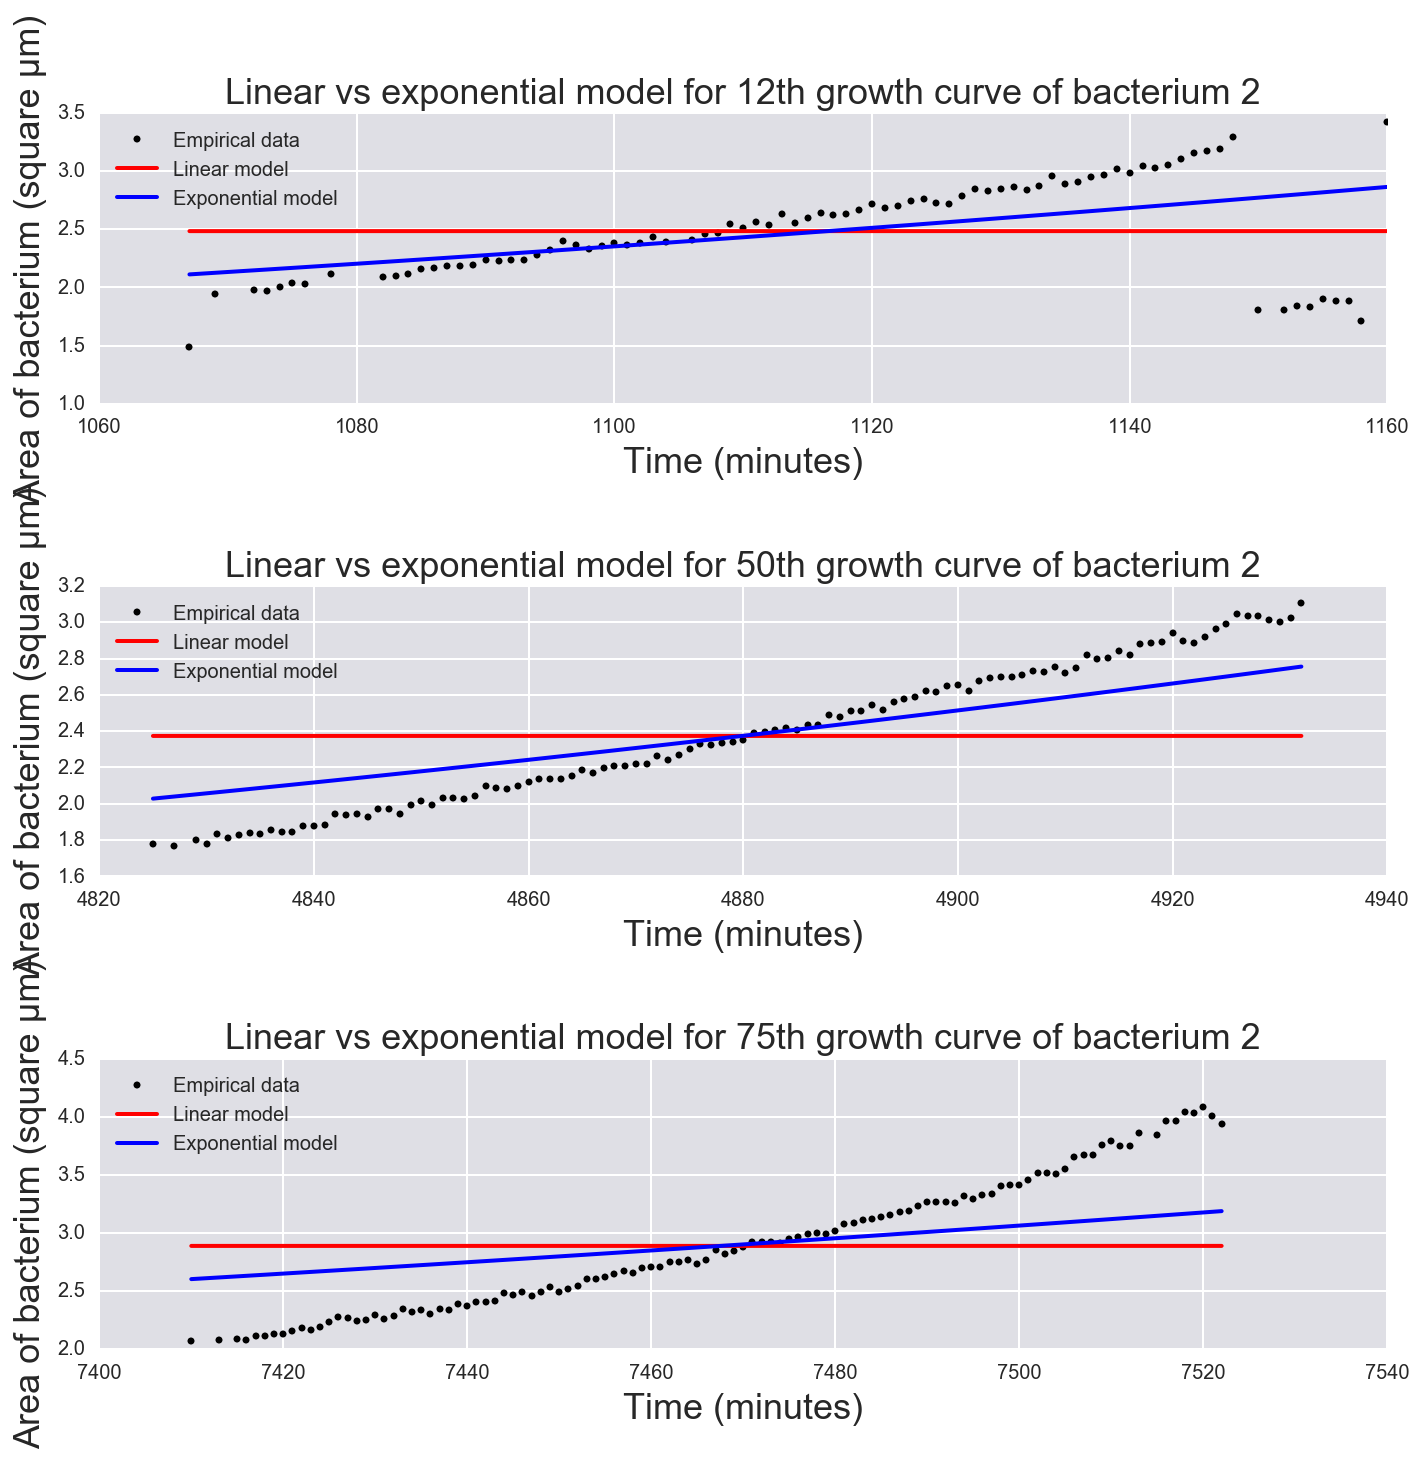

In [29]:
df_list = [df_11_lin, df_11_exp, df_49_lin, df_49_exp, df_74_lin, df_74_exp]
map1 = []
map2 = []

for i in range(len(df_list)):
    # Get the index of the most probable parameter set
    df_map = df_list[i][df_list[i].beta_ind == 0]
    max_ind = np.argmax(df_map.lnprob.values)

    # Pull out values.
    map_1, map_2 = df_map.values[max_ind, :2]

    map1.append(map_1)
    map2.append(map_2)

f = plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(time_series2[11], area_series2[11], '.', color='k')
plt.plot(time_series2[11],
         lin_theor(np.array([map1[0], map2[0]]), time_series2[11]), color='r')
plt.plot(time_series2[11],
         exp_theor(np.array([map1[1], map2[1]]), time_series2[11]), color='b')
plt.title('Linear vs exponential model for 12th growth curve of bacterium 2')
plt.xlabel('Time (minutes)')
plt.ylabel('Area of bacterium (square µm)')
plt.legend(['Empirical data', 'Linear model', 'Exponential model'], loc='topleft')

plt.subplot(3,1,2)
plt.plot(time_series2[49], area_series2[49], '.', color='k')
plt.plot(time_series2[49],
         lin_theor(np.array([map1[2], map2[2]]), time_series2[49]), color='r')
plt.plot(time_series2[49],
         exp_theor(np.array([map1[3], map2[3]]), time_series2[49]), color='b')
plt.title('Linear vs exponential model for 50th growth curve of bacterium 2')
plt.xlabel('Time (minutes)')
plt.ylabel('Area of bacterium (square µm)')
plt.legend(['Empirical data', 'Linear model', 'Exponential model'], loc='topleft')

plt.subplot(3,1,3)
plt.plot(time_series2[74], area_series2[74], '.', color='k')
plt.plot(time_series2[74],
         lin_theor(np.array([map1[4], map2[4]]), time_series2[74]), color='r')
plt.plot(time_series2[74],
         exp_theor(np.array([map1[5], map2[5]]), time_series2[74]), color='b')
plt.title('Linear vs exponential model for 75th growth curve of bacterium 2')
plt.xlabel('Time (minutes)')
plt.ylabel('Area of bacterium (square µm)')
plt.legend(['Empirical data', 'Linear model', 'Exponential model'], loc='topleft')
plt.tight_layout()

In [48]:
start = time.time()
df_1_lin2, lnZ_1_lin2, dlnZ_1_lin2 = sample_ptmcmc(time_series2[9], area_series2[9], 'lin_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

PTMCMC took 37.962949991226196  seconds.


In [49]:
start = time.time()
df_1_exp2, lnZ_1_exp2, dlnZ_1_exp2 = sample_ptmcmc(time_series2[9], area_series2[9], 'exp_theor', 
                                    n_temps=20, n_walkers=100, 
                                    n_burn=200, n_steps=1000, threads=3)
print('PTMCMC took', time.time()-start, ' seconds.')

PTMCMC took 43.36644506454468  seconds.


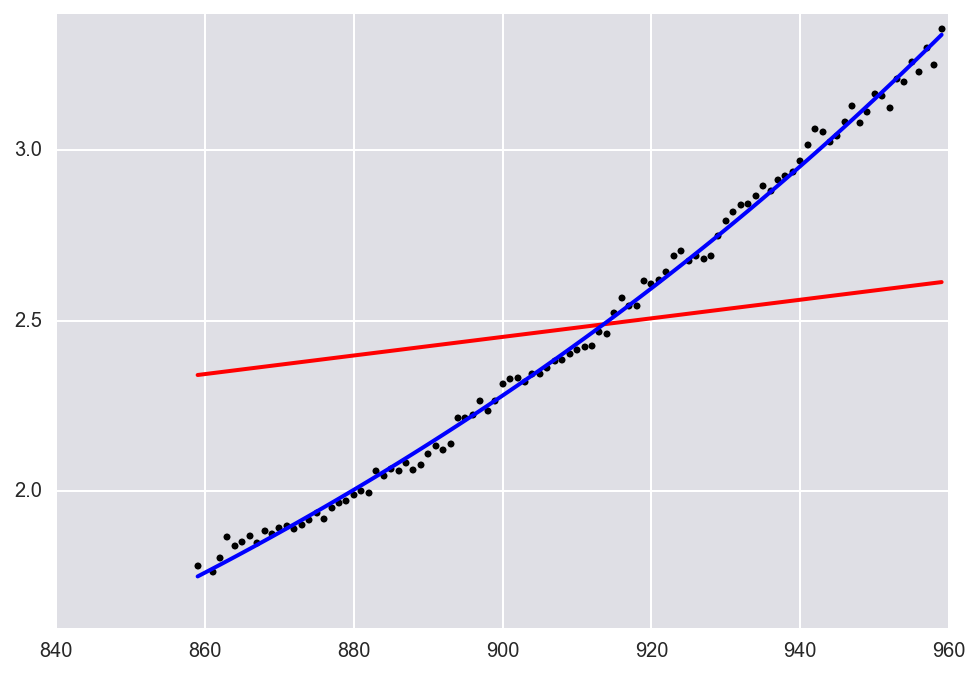

In [52]:
df_list = [df_1_lin2, df_1_exp2]
map1_new = []
map2_new = []
for i in range(len(df_list)):
    # Get the index of the most probable parameter set
    df_map = df_list[i][df_list[i].beta_ind == 0]
    max_ind = np.argmax(df_map.lnprob.values)

    # Pull out values.
    map_1, map_2 = df_map.values[max_ind, :2]

    map1_new.append(map_1)
    map2_new.append(map_2)

plt.plot(time_series2[9], area_series2[9], '.', color='k')
plt.plot(time_series2[9],
         lin_theor(np.array([map1_new[0], map2_new[0]]), time_series2[9]), color='r')
plt.plot(time_series2[9],
         exp_theor(np.array([map1_new[1], map2_new[1]]), time_series2[9]), color='b')